In [95]:
import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.regression.rolling import RollingOLS
from datetime import date
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [96]:
# download 2 stocks
s1 = yf.download('jpm', date(2019, 6, 1), date(2022, 7, 1))
s2 = yf.download('ms', date(2019, 6, 1), date(2022, 7, 1))
ma = 63
data = pd.DataFrame({'s1':s1['Adj Close'], 's2':s2['Adj Close']}, index = s1.index)
data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,s1,s2
Date,,
2019-06-03,96.553246,37.097763
2019-06-04,99.528015,38.691704
2019-06-05,99.881737,38.646168
2019-06-06,100.099411,38.992275
2019-06-07,99.002007,38.892090


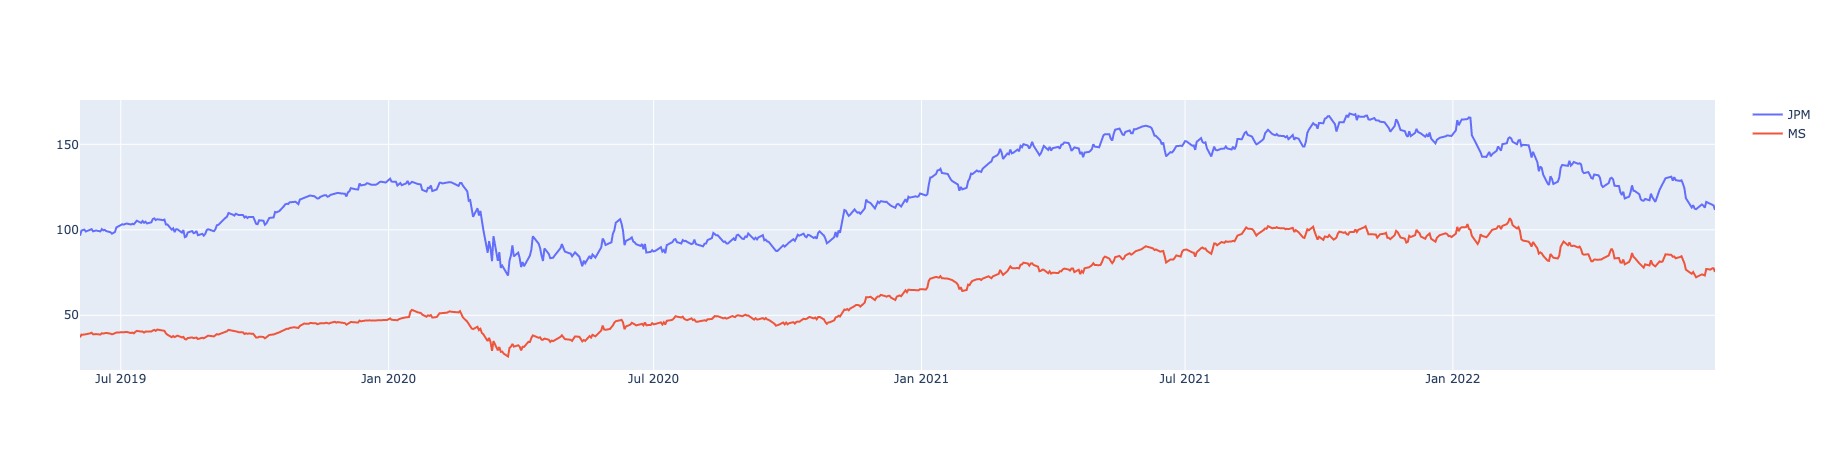

In [97]:
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=data.index, y=data['s1'], name='JPM'), row=1,col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['s2'], name='MS'), row=1,col=1)

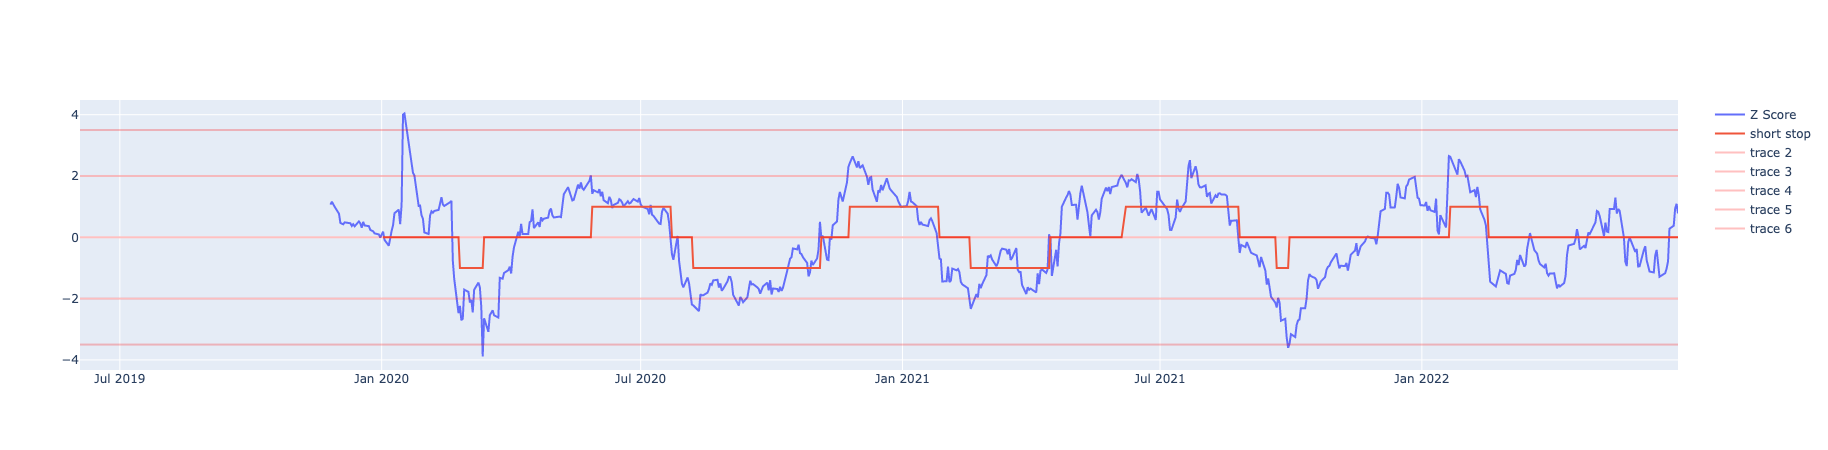

In [98]:
X1, X2 = np.log(data['s1']), np.log(data['s2'])

# create hedge ratio using rolling regression with 63 day window
data['Hedge Ratio'] = RollingOLS(X2, X1, window=ma).fit().params
data['Spread_1'] = X2 - X1*data['Hedge Ratio']

# calculate z score
data['Z_Score'] = (data['Spread_1']-data['Spread_1'].rolling(window=ma).mean())/data['Spread_1'].rolling(window=ma).std()

# given prices are daily close, we shift these periods by 1 day
# define regular trade boundaries
data['Trade periods short'] = data['Z_Score'].where((data['Z_Score'] >= 2)|(data['Z_Score'] <= 0)).ffill().shift(1)
data['Trade periods long'] = data['Z_Score'].where((data['Z_Score'] <= -2)|(data['Z_Score'] >= 0)).ffill().shift(1)

# define stopped trade boundaries
data['Trade periods stopped short'] = data['Z_Score'].where((data['Z_Score'] >= 3.5)|(data['Z_Score'] <= 0)).ffill().shift(1)
data['Trade periods stopped long'] = data['Z_Score'].where((data['Z_Score'] <= -3.5)|(data['Z_Score'] >= 0)).ffill().shift(1)

# create binary thresholds for short trades
data['Trades short'] = (np.sign(data['Trade periods short'])+1)/2
data['Trades stopped short'] = (np.sign(data['Trade periods stopped short'])+1)/2
# create binary thresholds for long trades
data['Trades long'] = -(1-(np.sign(data['Trade periods long'])))/2
data['Trades stopped long'] = -(1-(np.sign(data['Trade periods stopped long'])))/2
# sum trade thresholds 
data['all trades'] = data['Trades short'] + data['Trades long'] - data['Trades stopped short'] - data['Trades stopped long']

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=data.index, y=data['Z_Score'], name='Z Score'), row=1,col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["all trades"], name='short stop'), row=1,col=1)

# trade threshholds 
fig.add_trace(go.Scatter(x=data.index, y=[0]*len(data), line_color="#ff0000", opacity=0.25), row=1,col=1)
fig.add_trace(go.Scatter(x=data.index, y=[2]*len(data), line_color="#ff0000", opacity=0.25), row=1,col=1)
fig.add_trace(go.Scatter(x=data.index, y=[-2]*len(data), line_color="#ff0000", opacity=0.25), row=1,col=1)
fig.add_trace(go.Scatter(x=data.index, y=[3.5]*len(data), line_color="#ff0000", opacity=0.25), row=1,col=1)
fig.add_trace(go.Scatter(x=data.index, y=[-3.5]*len(data), line_color="#ff0000", opacity=0.25), row=1,col=1)

fig.update_layout(hovermode='x')
fig.show()

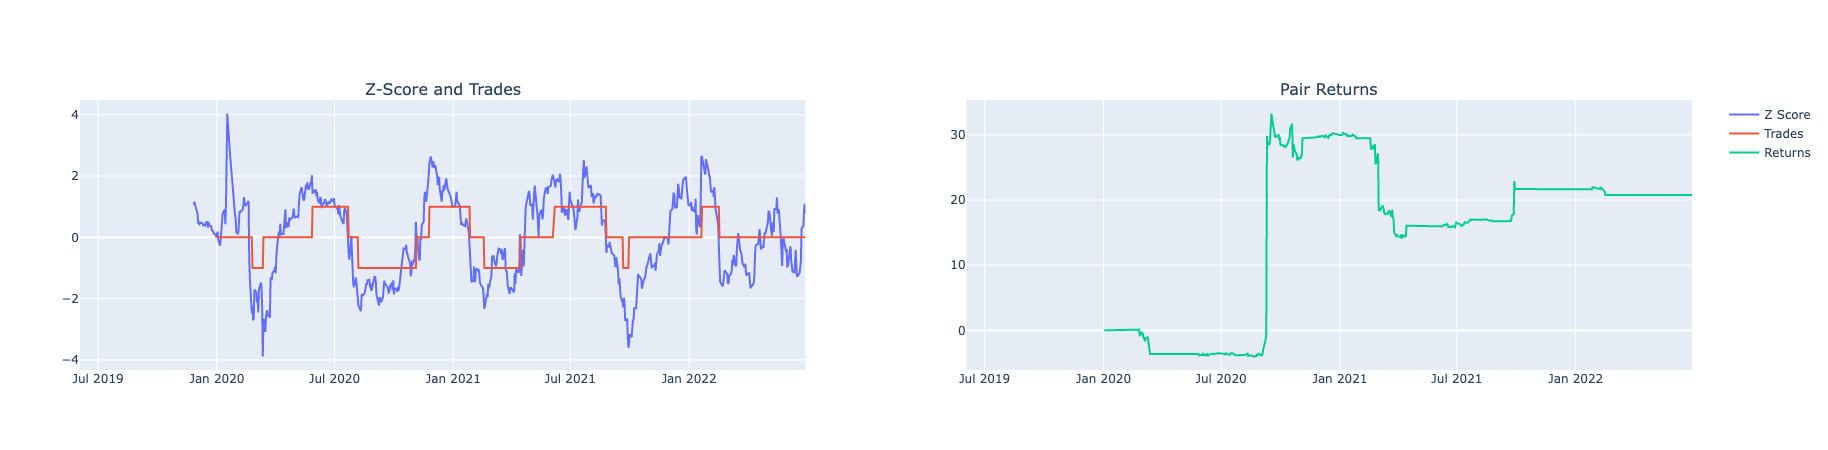

In [102]:
data['pair returns'] = ((((X2-data["Hedge Ratio"]*X1).pct_change()))*data['all trades']).cumsum()

fig = make_subplots(rows=1, cols=2, subplot_titles=("Z-Score and Trades", "Pair Returns"))
fig.add_trace(go.Scatter(x=data.index, y=data['Z_Score'], name='Z Score'), row=1,col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["all trades"], name='Trades'), row=1,col=1)
fig.add_trace(go.Scatter(x=data.index, y=data['pair returns'], name='Returns'), row=1,col=2)

fig.update_layout(hovermode='x')
fig.show()